# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [29]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [30]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [31]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
both_arms = good_arms + bad_arms
shuffle(both_arms)
arms = {arm.arm_id: arm for arm in both_arms}
arm_ids = list(arms.keys())

In [32]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.97892077958001


In [33]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [34]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [35]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [36]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 599.0200000000002
random: 288.40000000000003


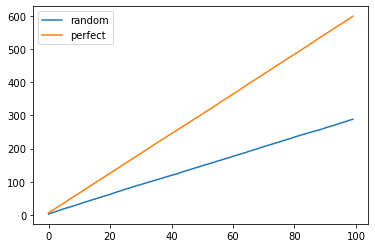

In [37]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 6.34
random: 2.52


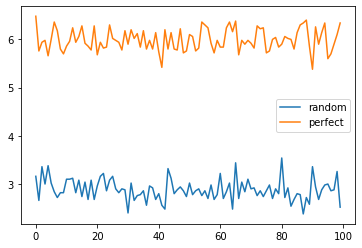

In [38]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [39]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        random_arm_ids = copy(arm_ids)
        shuffle(random_arm_ids)
        best_arm_ids = sorted(self.payouts_per_recommendation.items(), key=lambda payout_per_recommendation: payout_per_recommendation[1], reverse=True)
        result = []
        i = 0
        while len(result) < size:
            if random() < self.epsilon:
                choice = random_arm_ids[i]
            else:
                choice = best_arm_ids[i][0]
            if choice not in result:
                result.append(choice)
                self.recommended_rates[choice] += 1
            i = (i + 1) % size
        return result
        
        
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]
        
# egreedy = EGreedy('egreedy', arm_ids, 0.1)
# egreedy.recommend(10)

In [40]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        # te zera w mianowniku moga byc problematyczne
        # - zastanow sie, czy lepiej je obslugiwac w locie czy zainicjalizowac te mape wartosciami niezerowymi
        self.recommended_rates = {arm_id: 1 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 1 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 1
    
    def recommend(self, size):
        best_arm_ids = sorted(self.payouts_per_recommendation.items(), key=lambda payout_per_recommendation: payout_per_recommendation[1] + self._optimism(payout_per_recommendation[0]), reverse=True)
        self.n += size
        for arm_imd, _ in best_arm_ids[:size]:
            self.recommended_rates[arm_imd] += 1
        return [arm_id for arm_id, _ in best_arm_ids[:size]]
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        if self.recommended_rates[arm] == 0:
            return 1.0
        return self.optimism_weight * sqrt(log(self.n) / self.recommended_rates[arm])
    
# ucb = UCB('ucb', arm_ids, 1)
# ucb.feedback(ucb.recommend(1)[0], arms[ucb.recommend(1)[0]].pull())
# ucb.recommend(10)

In [41]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        betavariate_arms_dict = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in self.arm_ids}
        best_arm_ids = sorted(betavariate_arms_dict.items(), key=lambda betavariate_arm: betavariate_arm[1], reverse=True)
        return [arm_id for arm_id, _ in best_arm_ids[:size]]
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [42]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [43]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_5_5: 6.16
ts_5_10: 6.04
ts_5_1: 5.96
ts_10_10: 5.94
ts_20_1: 5.92
ts_5_20: 5.9
ts_5_50: 5.86
ts_1_10: 5.84
perfect: 5.82
ucb_1: 5.72
ts_10_20: 5.72
egreedy_0.05: 5.7
ts_20_20: 5.7
ts_1_5: 5.66
ts_50_5: 5.64
ts_1_1: 5.6
ts_10_50: 5.58
ts_20_5: 5.56
egreedy_0.1: 5.52
ts_10_1: 5.48
ts_1_50: 5.46
ts_20_10: 5.44
ts_10_5: 5.42
ts_1_20: 5.38
ts_50_1: 5.32
ts_50_20: 5.14
egreedy_0.25: 5.1
egreedy_0.01: 5.08
ts_50_10: 5.06
ucb_0.1: 4.82
ts_50_50: 4.72
ts_20_50: 4.66
ucb_0.01: 3.86
random: 2.96
ucb_10: 2.9


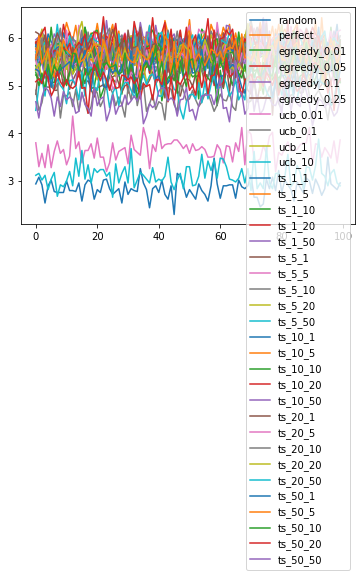

In [44]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 595.6400000000001
ts_5_10: 587.9999999999998
ts_5_5: 587.3799999999999
ts_10_20: 585.9999999999999
ts_1_5: 585.1000000000001
ts_1_50: 583.9599999999999
ts_5_50: 583.5400000000001
ts_1_10: 582.74
ts_1_20: 581.3799999999999
ts_5_20: 579.1599999999999
ts_1_1: 578.22
ts_5_1: 571.08
ts_20_1: 567.5200000000001
ts_10_1: 565.7399999999999
ts_50_5: 564.3800000000001
ts_10_5: 561.8399999999996
egreedy_0.1: 560.4999999999999
ts_10_10: 559.5
ts_10_50: 558.1399999999999
egreedy_0.05: 552.3799999999999
ts_20_10: 552.2800000000001
ts_20_20: 550.8199999999998
ucb_1: 547.3400000000001
ts_20_5: 544.4799999999999
ts_50_10: 532.96
ts_50_1: 528.9999999999998
egreedy_0.01: 521.4799999999999
egreedy_0.25: 511.70000000000005
ts_50_20: 508.2599999999999
ts_20_50: 496.3000000000001
ucb_0.1: 475.7200000000001
ts_50_50: 466.0000000000002
ucb_0.01: 366.06
ucb_10: 312.9
random: 285.31999999999994


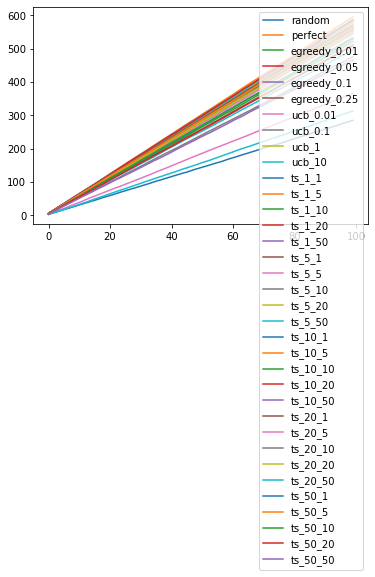

In [45]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [46]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    # calculate all arms that start with good_
    return len([arm for arm in recommendation if arm.arm_id.startswith('good_')])

all_relevant = relevant(arms.values())
all_relevant

10

In [47]:
# obliczmy precision@k i recall@k (zgodnie ze wzorami z wykladu)
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation[:k]) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation[:k]) / all_relevant

In [48]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [49]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = [
    bandit for bandit in bandits
    if bandit.bandit_id in ['perfect', 'random', 'egreedy_0.25', 'ucb_1', 'ts_1_1']]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, wypisujemy srednie wartosci
# powtarzamy dla kazdego k
for k in k_vals:
    print(f'Precision@{k} and recall@{k} for {samples} samples:')
    for bandit in tesing_bandits:
        precisions = []
        recalls = []
        for _ in range(samples):
            recommendation_ids = bandit.recommend(recommendation_size)
            recommendation = [arms[arm_id] for arm_id in recommendation_ids]
            precisions.append(precision_at_k(recommendation, k))
            recalls.append(recall_at_k(recommendation, k, all_relevant))
        print(f'{bandit.bandit_id}: precision: {sum(precisions)/samples}, recall: {sum(recalls)/samples}')
    print()

Precision@3 and recall@3 for 10 samples:
random: precision: 0.06666666666666667, recall: 0.02
perfect: precision: 1.0, recall: 0.29999999999999993
egreedy_0.25: precision: 0.8666666666666668, recall: 0.26
ucb_1: precision: 1.0, recall: 0.29999999999999993
ts_1_1: precision: 1.0, recall: 0.29999999999999993

Precision@5 and recall@5 for 10 samples:
random: precision: 0.18, recall: 0.09
perfect: precision: 1.0, recall: 0.5
egreedy_0.25: precision: 0.7, recall: 0.35
ucb_1: precision: 1.0, recall: 0.5
ts_1_1: precision: 1.0, recall: 0.5

Precision@10 and recall@10 for 10 samples:
random: precision: 0.06999999999999999, recall: 0.06999999999999999
perfect: precision: 1.0, recall: 1.0
egreedy_0.25: precision: 0.7500000000000001, recall: 0.7500000000000001
ucb_1: precision: 0.9400000000000001, recall: 0.9400000000000001
ts_1_1: precision: 0.99, recall: 0.99
